In [1]:
%reset
import numpy as np
from math import nan,isnan
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d as gaussian
from scipy.signal import decimate,convolve
from rtlsdr import RtlSdr
from time import sleep

global pi,i
pi =np.pi
i = np.complex(0,1)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# configure device & capture data
freq = 935.2e+6
sample_rate = 2280000
bandwidth = 200e+3
nr_samples = 2**18
time_interval = nr_samples/sample_rate

sdr = RtlSdr()
sleep(1)
sdr.sample_rate = sample_rate
sdr.center_freq = freq
sdr.bandwidth = bandwidth
sdr.freq_correction = 60 #PPM
sdr.gain = 'auto'
samples = sdr.read_samples(nr_samples)
sdr.close()

In [3]:
#gsm burst and capture parameters
burst_time = 576.9e-6 #burst time
burst_symbols = 156.25 #bits per burst
bps = burst_symbols/burst_time #bits per second
sample_per_burst = sample_rate*burst_time
sample_per_bit = sample_per_burst/burst_symbols
print('bits per second: ',bps)
print('time per bit: ',1/bps)
print('samples captured per burst:',sample_per_burst)
print('samples per bit:',sample_per_bit)

bits per second:  270844.16710001737
time per bit:  3.6921599999999997e-06
samples captured per burst: 1315.3319999999999
samples per bit: 8.4181248


[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1]
bits:  150


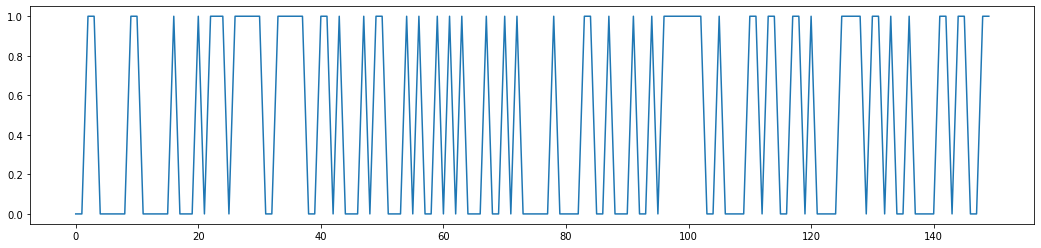

In [11]:
abs2 = lambda x: np.square(np.real(x)) + np.square(np.imag(x))
phase_diff = lambda x: np.diff(np.imag(x))*np.real(x)[1:] - np.diff(np.real(x))*np.imag(x)[1:]

#find power increase of signal (start of burst)
mask = abs2(samples)
mask = mask>np.sum(mask)*0.3/(nr_samples)
start_points_candidate = np.where(np.diff(mask))[0]
ind = (start_points_candidate[1:]-start_points_candidate[:-1])>0.5*sample_per_burst
start_points = list( start_points_candidate[np.where(ind)] )

#extract data
burst_samples = int(sample_per_burst)
for p in start_points:
    #decode
    data = phase_diff(samples[p:p+burst_samples])
    data = gaussian(data,1)
    
    #digitize
    average = np.sum(data)/burst_samples
    data = data>average
    data = data.astype(int)
    change = np.diff(data)
    time = np.where(np.not_equal(change,0))[0]
    result = []
    for iii in range(time.size-1):
        bits = round((time[iii+1]-time[iii])/sample_per_bit)
        value = data[time[iii]+1]
        value = (value + 1)%2 #reverse bits
        result.extend([value]*bits)
    
    #visualize
    plt.figure(figsize=(18,4))
    plt.plot(result)
    print(result)
    print('bits: ',len(result))
    break

#remaining = samples[p+burst_samples:]

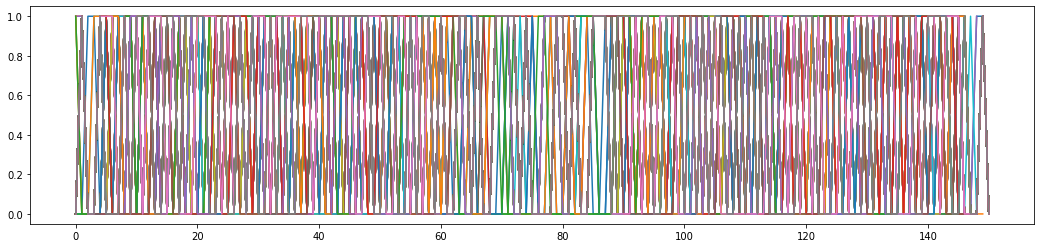

In [12]:
abs2 = lambda x: np.square(np.real(x)) + np.square(np.imag(x))
phase_diff = lambda x: np.diff(np.imag(x))*np.real(x)[1:] - np.diff(np.real(x))*np.imag(x)[1:]

#find power increase of signal (start of burst)
mask = abs2(samples)
mask = mask>np.sum(mask)*0.3/(nr_samples)
start_points_candidate = np.where(np.diff(mask))[0]
ind = (start_points_candidate[1:]-start_points_candidate[:-1])>0.5*sample_per_burst
start_points = list( start_points_candidate[np.where(ind)] )

f = open('gsm.txt','w')

#extract data
burst_samples = int(sample_per_burst)
plt.figure(figsize=(18,4))
for p in start_points:
    #decode
    data = phase_diff(samples[p:p+burst_samples])
    data = gaussian(data,1)
    
    #digitize
    average = np.sum(data)/burst_samples
    data = data>average
    data = data.astype(int)
    change = np.diff(data)
    time = np.where(np.not_equal(change,0))[0]
    result = []
    for iii in range(time.size-1):
        bits = round((time[iii+1]-time[iii])/sample_per_bit)
        value = data[time[iii]+1]
        value = (value + 1)%2 #reverse bits
        result.extend([value]*bits)
    
    #visualize
    plt.plot(result)
    #print(result)
    #print('bits: ',len(result))
    f.write(str((result)).replace(', ','')+'\n')
    #break

f.close()
#remaining = samples[p+burst_samples:]

In [105]:
#gsm decode from stackexchange by noiam (https://stackoverflow.com/questions/13130935/decode-7-bit-gsm)
def gsm7bitdecode(f):
   f = ''.join(["{0:08b}".format(int(f[i:i+2], 16)) for i in range(0, len(f), 2)][::-1])
   return ''.join([chr(int(f[::-1][i:i+7][::-1], 2)) for i in range(0, len(f), 7)])
print(gsm7bitdecode('C7F7FBCC2E03'))

Google 
